# AIAP 20 - Technical Assessment
## Task 1 - Exploratory Data Analysis (EDA)

NOTE: Before running Step 1, run "install_venv.sh" in the project folder to setup the Virtual Environment.

### Step 1: Setup

Check and ACTIVATE Virtual Environment (venv)

In [1]:
import os
import subprocess
import sys

# Define the virtual environment folder
venv_path = "venv"

# Function to create a virtual environment if it doesn't exist
def create_venv():
    print(f"Virtual environment '{venv_path}' not found. Creating it...")
    subprocess.check_call([sys.executable, "-m", "venv", venv_path])

# Check if virtual environment exists
if not os.path.exists(venv_path):
    create_venv()

# Activate the virtual environment
activate_script = os.path.join(venv_path, "bin", "activate")  # Default for macOS/Linux
if sys.platform == "win32":
    activate_script = os.path.join(venv_path, "Scripts", "activate.bat")  # Windows

# Activate virtual environment by running the activation script
print(f"Activating virtual environment at: {activate_script}")
subprocess.call([activate_script], shell=True)

# Install ipykernel in the virtual environment if it's not installed
subprocess.check_call([sys.executable, "-m", "pip", "install", "ipykernel"])

# Add the virtual environment as a Jupyter kernel
subprocess.check_call(
    [
        sys.executable,
        "-m",
        "ipykernel",
        "install",
        "--user",
        "--name=myenv",
        "--display-name=Python (myenv)",
    ]
)

print(f"Virtual environment '{venv_path}' is ready and added as a Jupyter kernel.")


Activating virtual environment at: venv\Scripts\activate.bat
Virtual environment 'venv' is ready and added as a Jupyter kernel.


Install Libraries

In [2]:
%pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


Import Libraries

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Import Database and convert to DataFrame
- Connect to SQLite db from the given bmarket.db file.
- Convert to DataFrame for analysis.
- Reference: docs.python.org/3/library/sqlite3.html

In [4]:
# Connect to SQLite db
con = sqlite3.connect("data/bmarket.db") # connect to SQLite database
curr = con.cursor()


In [5]:
# Get The Table Name

curr.execute("SELECT name FROM sqlite_master WHERE type = 'table';")
tables = curr.fetchall()


print (tables) # check how many tables are there in the db.

def table_name(): # function used to assign table name
    for table in tables:
        return table[0]

print(table_name())

[('bank_marketing',)]
bank_marketing


In [6]:
# Convert .db to DataFrame(pd)
dataset_raw = pd.read_sql_query(f"SELECT * FROM {table_name()}", con)

con.close()

### Step 3: Dataset Exploration - Data Inspection & Cleaning
Check for basic information of the dataset to get to know the data and clean as we move along with the exploration.

In [7]:
# Check for duplicate rows
int(dataset_raw.duplicated().sum())

0

There is no duplicated rows

In [8]:
# Checking for missing values
dataset_raw.isnull().sum()

Client ID                    0
Age                          0
Occupation                   0
Marital Status               0
Education Level              0
Credit Default               0
Housing Loan             24789
Personal Loan             4146
Contact Method               0
Campaign Calls               0
Previous Contact Days        0
Subscription Status          0
dtype: int64

In [9]:
# Verify the unique values present in Housing Loan and Personal Loan since they contain missing values.
print("Unique Values for Housing Loan", dataset_raw["Housing Loan"].unique())
print("Unique Values for Personal Loan",dataset_raw["Personal Loan"].unique())

Unique Values for Housing Loan ['no' 'yes' None 'unknown']
Unique Values for Personal Loan ['yes' 'no' None 'unknown']


There is a chance that Housing Loan and Personal Loan will affect the probability of client taking up Term Deposit, so to clean the missing values, change the None to unknown instead of dropping them.

In [10]:
# Replace None (actual missing values) with 'unknown'
dataset_raw["Housing Loan"] = dataset_raw["Housing Loan"].fillna("unknown")
dataset_raw["Personal Loan"] = dataset_raw["Personal Loan"].fillna("unknown")

In [11]:
# Verify that there is no None (missing values)
print("Unique Values for Housing Loan", dataset_raw["Housing Loan"].unique())
print("Unique Values for Personal Loan",dataset_raw["Personal Loan"].unique())

Unique Values for Housing Loan ['no' 'yes' 'unknown']
Unique Values for Personal Loan ['yes' 'no' 'unknown']


In [12]:
# Check for type, row, column, non-null values
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           41188 non-null  object
 7   Personal Loan          41188 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


The dataset has 41188 rows and 12 columns, and Housing Loan and Personal Loan column contains missing values previously that has been cleaned.

In [13]:
# Check the Header
dataset_raw.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
0,32885,57 years,technician,married,high.school,no,no,yes,Cell,1,999,no
1,3170,55 years,unknown,married,unknown,unknown,yes,no,telephone,2,999,no
2,32207,33 years,blue-collar,married,basic.9y,no,no,no,cellular,1,999,no
3,9404,36 years,admin.,married,high.school,no,no,no,Telephone,4,999,no
4,14021,27 years,housemaid,married,high.school,no,unknown,no,Cell,2,999,no


Based on the insights above, for **Age** remove the years for better statistical analysis. <br>
For **Education Level**, standardization is required to minimize the unique values that is not crucial to the data, such as combining all basic.#y into **Basic Education**

#### Checking Categorical Values

In [14]:
# Verify the unique values of "Education Level"
dataset_raw["Education Level"].unique()

array(['high.school', 'unknown', 'basic.9y', 'professional.course',
       'university.degree', 'basic.4y', 'basic.6y', 'illiterate'],
      dtype=object)

Replace #.years with integer value of Age

In [15]:
# Remove the text years from the values of **Age** and convert the type to int.
dataset_raw['Age'] = dataset_raw['Age'].str.replace(' years', '').astype(int)
dataset_raw.dtypes

Client ID                 int64
Age                       int64
Occupation               object
Marital Status           object
Education Level          object
Credit Default           object
Housing Loan             object
Personal Loan            object
Contact Method           object
Campaign Calls            int64
Previous Contact Days     int64
Subscription Status      object
dtype: object

Improve the object text and combine all basic.#y to Basic Education.

In [16]:
# Mapping values for Education Level
education_mapping = {
    'high.school': 'High School',
    'unknown': 'Unknown',
    'basic.9y': 'Basic Education',
    'basic.4y': 'Basic Education',
    'basic.6y': 'Basic Education',
    'professional.course': 'Professional Course',
    'university.degree': 'University Degree',
    'illiterate': 'Illiterate'
}

dataset_raw["Education Level"] = dataset_raw["Education Level"].map(education_mapping)

dataset_raw["Education Level"].unique()

array(['High School', 'Unknown', 'Basic Education', 'Professional Course',
       'University Degree', 'Illiterate'], dtype=object)

Based on the remaining columns' unique values we can verify to see further cleaning is necessary.

In [17]:
print("Unique Values Age", dataset_raw["Age"].unique())
print("Unique Values Occupation", dataset_raw["Occupation"].unique())
print("Unique Values Marital Status", dataset_raw["Marital Status"].unique())
print("Unique Values Credit Default", dataset_raw["Credit Default"].unique())
print("Unique Values Housing Loan", dataset_raw["Housing Loan"].unique())
print("Unique Values Personal Loan", dataset_raw["Personal Loan"].unique())
print("Unique Values Contact Method", dataset_raw["Contact Method"].unique())
print("Unique Values Campaign Calls", dataset_raw["Campaign Calls"].unique())
print("Unique Values Previous Contact Days", dataset_raw["Previous Contact Days"].unique())
print("Unique Values Subscription Status ", dataset_raw["Subscription Status"].unique())

Unique Values Age [ 57  55  33  36  27  58  48 150  24  34  42  43  26  37  46  59  49  30
  51  45  31  41  38  47  69  50  25  39  44  52  35  77  40  56  53  60
  29  28  54  32  81  63  21  22  74  80  62  68  86  23  71  67  65  20
  19  66  75  18  72  70  82  85  61  88  83  78  64  17  76  73  79  89
  84  91  98  92  95]
Unique Values Occupation ['technician' 'unknown' 'blue-collar' 'admin.' 'housemaid' 'retired'
 'services' 'entrepreneur' 'unemployed' 'management' 'self-employed'
 'student']
Unique Values Marital Status ['married' 'divorced' 'single' 'unknown']
Unique Values Credit Default ['no' 'unknown' 'yes']
Unique Values Housing Loan ['no' 'yes' 'unknown']
Unique Values Personal Loan ['yes' 'no' 'unknown']
Unique Values Contact Method ['Cell' 'telephone' 'cellular' 'Telephone']
Unique Values Campaign Calls [  1   2   4   7   3 -11  15  -3  12   9  -1   5  -9  -5   6  13  -2  14
 -12  42   8  11  -4  17  18  10  -8  -6  28  33  -7  16  24  20  21  22
  23 -14  19 -29  26 

From the outputs, further cleaning is required for:
- Occupation replace admin. with administrator.
- Contact Method has typo error and case issues.
- Campaign Calls should not have negative values, check if negative value is outliers later.

Replace "Occupation" values for admin. with administrator.

In [18]:
# replace admin. with administrator
dataset_raw["Occupation"] = dataset_raw["Occupation"].replace("admin.", "administrator")

# check if replacement is done
dataset_raw["Occupation"].unique()

array(['technician', 'unknown', 'blue-collar', 'administrator',
       'housemaid', 'retired', 'services', 'entrepreneur', 'unemployed',
       'management', 'self-employed', 'student'], dtype=object)

Replace "Contact Method" values:
1. Cell to cellular
2. Telephone to telephone

In [19]:
# replace Cell with cellular and convert all string to lower case.

dataset_raw["Contact Method"] = dataset_raw["Contact Method"].replace("Cell", "cellular").str.lower()

# check if change is done
dataset_raw["Contact Method"].unique()



array(['cellular', 'telephone'], dtype=object)

#### Checking Numeric Values

In [20]:
# Describe the dataset for numerical features
dataset_raw.describe()

,Client ID,Age,Campaign Calls,Previous Contact Days
count,41188.00000,41188.000000,41188.000000,41188.000000
mean,20594.50000,51.231572,2.051374,962.475454
std,11890.09578,34.708486,3.171345,186.910907
min,1.00000,17.000000,-41.000000,0.000000
25%,10297.75000,33.000000,1.000000,999.000000
50%,20594.50000,40.000000,2.000000,999.000000
75%,30891.25000,51.000000,3.000000,999.000000
max,41188.00000,150.000000,56.000000,999.000000


Based on the statisical overview of the numeric columns
- Client ID can be ignored as it is a identifier and doesn't provide meaningful insights
- Age: Max age is too high. Investigate further.
- Campaign Calls: Has negative values as mentioned previously. Investigate further
- Previous Contact Days: Has 999 (no contact). Remove 999 to get a meaningful insight for contact days.

#### Checking Numeric Values - Age : Check for data error in Age

Histogram to check for outliers/anormalities.

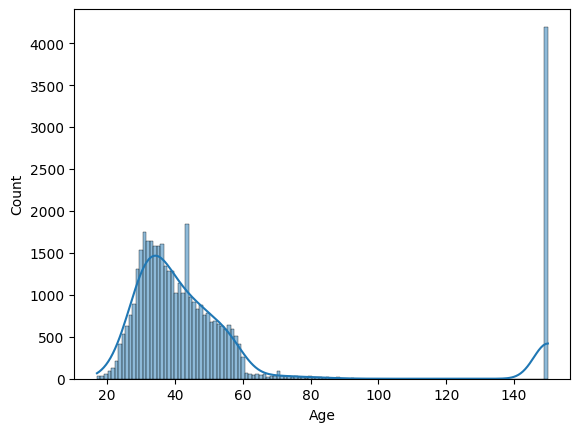

In [21]:
sns.histplot(dataset_raw['Age'], kde=True)
plt.show()

Scatterplot to check for outliers/anormalities.

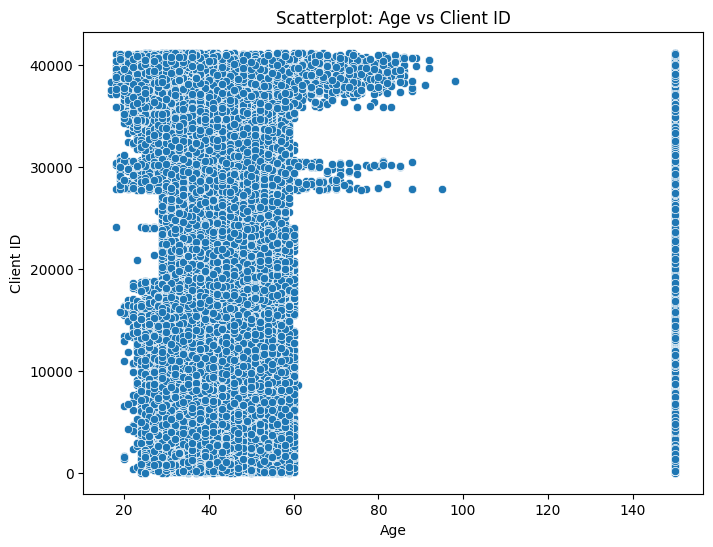

In [22]:
# Scatterplot to check for outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dataset_raw['Age'], y=dataset_raw['Client ID'])

# Title and labels
plt.title("Scatterplot: Age vs Client ID")
plt.xlabel("Age")
plt.ylabel("Client ID")

plt.show()




The histogram and scatterplot shows that there is a flat trend and outliers at around 90+ to 150. Age above 100 is very uncommon.

In [23]:
# Verify the shape of dataset for Age > 100 and entire dataset

print("Age Shape", dataset_raw[dataset_raw["Age"] > 100].shape)
print("Dataset Shape", dataset_raw.shape)

Age Shape (4197, 12)
Dataset Shape (41188, 12)


Since age is an important predictive feature, records with Age > 100 (around 10% of entire dataset) are removed to eliminate likely outliers and ensure model accuracy.

In [24]:
# drop rows by filtering where Age <= 100
dataset_raw = dataset_raw[dataset_raw["Age"] <= 100]

# Verify that rows are dropped.
dataset_raw.shape

(36991, 12)

Rows with Age >= 100 are dropped, before 41188 now 36991

#### Checking Numeric Values - Campaign Calls : Check for data error in Campaign Calls

Histogram to check for outliers/anormalities.

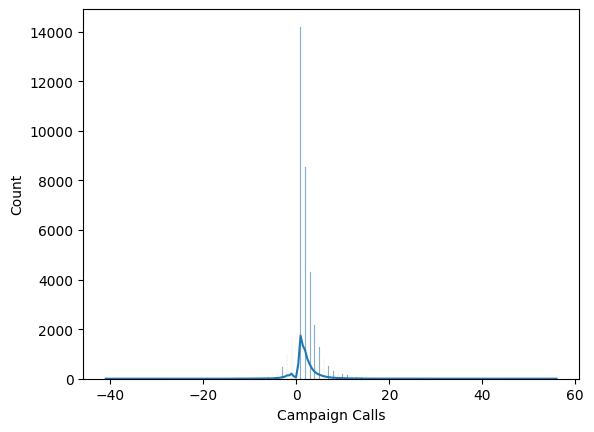

In [25]:
sns.histplot(dataset_raw['Campaign Calls'], kde=True)
plt.show()

Scatterplot to check for outliers/anormalities.

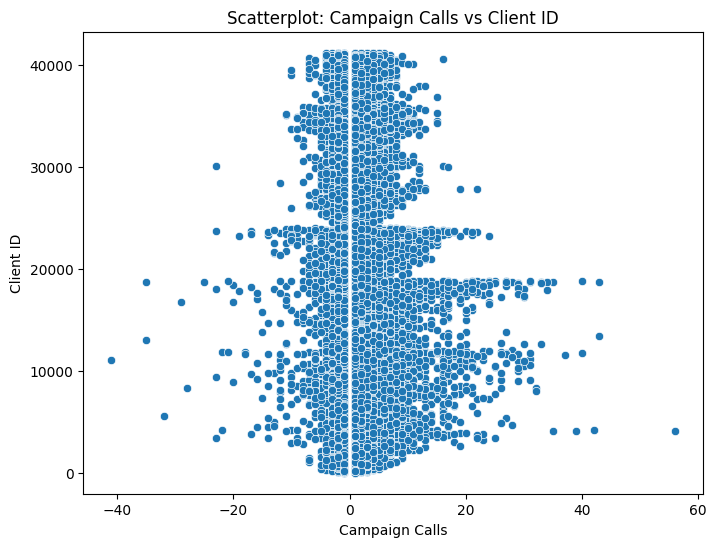

In [26]:
# Scatterplot to check for outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dataset_raw["Campaign Calls"], y=dataset_raw["Client ID"])

# Title and labels
plt.title("Scatterplot: Campaign Calls vs Client ID")
plt.xlabel("Campaign Calls")
plt.ylabel("Client ID")

plt.show()

 Since it's not logically meaningful for 'Campaign Calls' value to be less than 0. Check size of rows that is less than 0 to decide if dropping them might result in a low quality data.

In [27]:
# Verify the size of dataset vs "Campaign Calls" < 0

print("Shape of Dataset:", dataset_raw.shape)
print("Shape of Dataset for Campaign Call < 0 only:", dataset_raw[dataset_raw["Campaign Calls"]<0].shape)

Shape of Dataset: (36991, 12)
Shape of Dataset for Campaign Call < 0 only: (3744, 12)


Since the "Campaign Calls" that is less than 0 result in around 10% of the dataset we can safely drop it without affect the data quality.

In [28]:
dataset_raw = dataset_raw[dataset_raw["Campaign Calls"] >= 0]
dataset_raw.shape

(33247, 12)

Dropped rows that is less than 0 including only "Campaign Calls" >= 0

#### Checking Numeric Values - Previous Contact Days : Check for data error in Previous Contact Days

Histogram to check for outliers/anormalities.

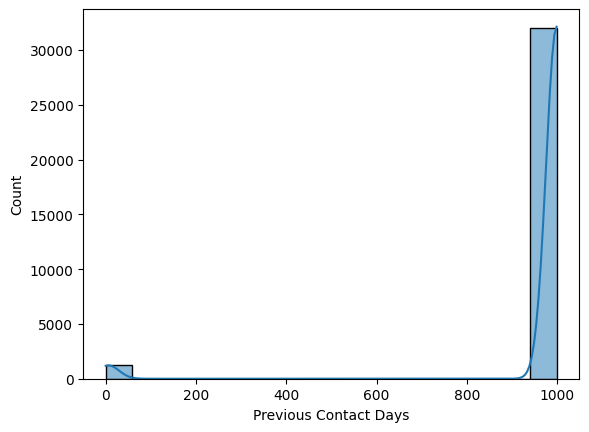

In [29]:
sns.histplot(dataset_raw['Previous Contact Days'], kde=True)
plt.show()

Scatterplot to check for outliers/anormalities.

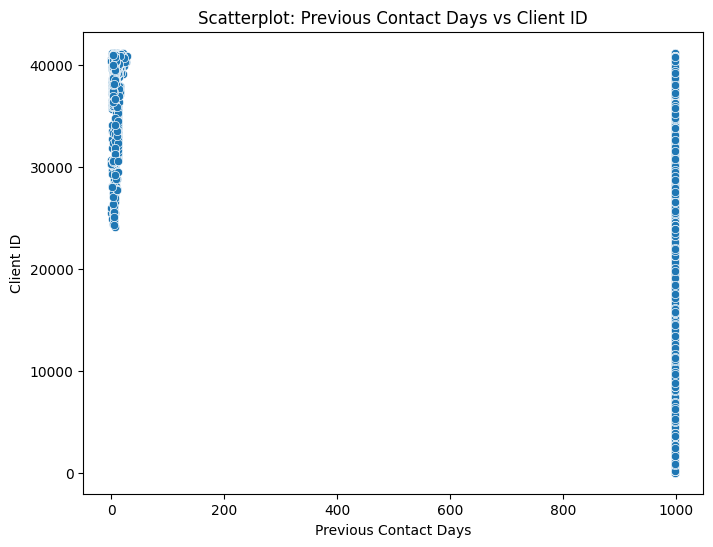

In [30]:
# Scatterplot to check for outliers
plt.figure(figsize=(8, 6))
sns.scatterplot(x=dataset_raw['Previous Contact Days'], y=dataset_raw['Client ID'])

# Title and labels
plt.title("Scatterplot: Previous Contact Days vs Client ID")
plt.xlabel("Previous Contact Days")
plt.ylabel("Client ID")

plt.show()

Check the size of the dataset that contains Previous Contact Days = 999

In [31]:
dataset_raw[dataset_raw["Previous Contact Days"]==999].shape

(32017, 12)

Since the value 999 (representing 'No Prior Contact') significantly impacts the volume of the data (32017), it should be retained. Instead of leaving it as-is, we create an indicator column to distinguish between clients with no prior contact and those with prior contact. When the value is 1, it indicates no prior contact. This allows us to filter the data easily based on this condition.

In [32]:
# Create a new column 'No Previous Contact' to indicate if the client had no prior contact (999)
dataset_raw["No Previous Contact"] = dataset_raw["Previous Contact Days"].apply(lambda x: 1 if x == 999 else 0)

In [33]:
dataset_raw[dataset_raw["No Previous Contact"] == 0].head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,No Previous Contact
42,41021,25,student,single,High School,no,yes,no,cellular,1,3,yes,0
53,33790,24,administrator,married,Basic Education,no,unknown,no,cellular,1,10,yes,0
58,39197,41,administrator,divorced,University Degree,no,yes,unknown,cellular,2,6,yes,0
91,41032,25,student,single,High School,no,yes,no,cellular,1,6,no,0
137,40820,31,administrator,married,University Degree,no,unknown,no,cellular,2,13,yes,0


Now new column "No Previous Contact" is created to indicate "With" and "Without" Previous Contact using 1 and 0

In [34]:
# Double Check the Cleaned Data

dataset_raw.head()

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status,No Previous Contact
0,32885,57,technician,married,High School,no,no,yes,cellular,1,999,no,1
1,3170,55,unknown,married,Unknown,unknown,yes,no,telephone,2,999,no,1
2,32207,33,blue-collar,married,Basic Education,no,no,no,cellular,1,999,no,1
3,9404,36,administrator,married,High School,no,no,no,telephone,4,999,no,1
4,14021,27,housemaid,married,High School,no,unknown,no,cellular,2,999,no,1


Check the distribution of the Label "Subscription Status"

In [35]:
# Create a new dataset with mapped values for 'Subscription Status'
mapped_dataset = dataset_raw.copy()
mapped_dataset['Subscription Status Mapped'] = mapped_dataset['Subscription Status'].map({'yes': 1, 'no': 0})

# Show the value counts for the mapped 'Subscription Status'
print(mapped_dataset['Subscription Status Mapped'].value_counts())

Subscription Status Mapped
0    29431
1     3816
Name: count, dtype: int64


There are 3816 clients subscribed to Term Deposit out of a total of 33247.

----------

### Step 4: Explore Relationships

Now that the data is cleaned, the next step is to explore relationships between **features** and determine how they influence the **label**, "Subscription Status". 

In [36]:
dataset_encoded = pd.get_dummies(dataset_raw, drop_first=False)
dataset_encoded = dataset_encoded.astype(int)
dataset_encoded.head()

,Client ID,Age,Campaign Calls,Previous Contact Days,No Previous Contact,Occupation_administrator,Occupation_blue-collar,Occupation_entrepreneur,Occupation_housemaid,Occupation_management,...,Housing Loan_no,Housing Loan_unknown,Housing Loan_yes,Personal Loan_no,Personal Loan_unknown,Personal Loan_yes,Contact Method_cellular,Contact Method_telephone,Subscription Status_no,Subscription Status_yes
0,32885,57,1,999,1,0,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
1,3170,55,2,999,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,1,0
2,32207,33,1,999,1,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,9404,36,4,999,1,1,0,0,0,0,...,1,0,0,1,0,0,0,1,1,0
4,14021,27,2,999,1,0,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0


### Correlation Matrix
https://developers.google.com/machine-learning/crash-course/linear-regression/programming-exercise

- 1.0: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
- -1.0: perfect negative correlation; that is, when one attribute rises, the other attribute falls.
- 0.0: no correlation; the two columns are not linearly related.

Since the label is "Subscription Status" but it's in categorical value we can change it to numeric value to be interpreted in Correlation Matrix that only allows numeric values.

In [37]:

# Calculate correlation matrix on numeric columns only
corr_matrix = dataset_encoded.corr(numeric_only=True)

correlation_with_target = corr_matrix['Subscription Status_yes'].drop('Client ID').sort_values(ascending=False)
print(correlation_with_target)




Subscription Status_yes                1.000000
Contact Method_cellular                0.144335
Credit Default_no                      0.099741
Occupation_student                     0.096966
Occupation_retired                     0.092283
Marital Status_single                  0.055536
Education Level_University Degree      0.048767
Age                                    0.031399
Occupation_administrator               0.028775
Education Level_Unknown                0.021392
Occupation_unemployed                  0.014035
Education Level_Illiterate             0.011007
Housing Loan_yes                       0.010448
Personal Loan_no                       0.006806
Occupation_unknown                     0.005664
Marital Status_unknown                 0.003289
Occupation_management                  0.000779
Education Level_Professional Course   -0.000903
Occupation_self-employed              -0.001867
Personal Loan_unknown                 -0.003274
Credit Default_yes                    -0

There is a **moderate positive correlation** with Subscription Status with certain features like Contact Method_cellular (0.1443), and Occupation_student (0.0969), indicating some level of association between these features and subscription.

There is a **weak positive correlation** with Features like Age (0.0314) and Education Level_University Degree (0.0488) meaning that they have a small influence on subscription behavior but are not dominant predictors.

Some features have **weak to moderate negative correlations**, such as Campaign Calls (-0.0657) and Occupation_blue-collar (-0.0755), suggesting that more campaign calls or certain occupations could have a slight negative impact on the likelihood of subscribing.

Previous Contact Days (-0.3219) and No Previous Contact (-0.3219) show **moderate negative correlations**, meaning customers who have had more previous contacts or no previous contact at all are less likely to subscribe. This might be a strong indicator of customer behavior and could be useful in a predictive model.

While there is no single feature with a very high correlation, there are multiple features that have some degree of correlation with subscription status, both positive and negative.

### Plots

#### Subscription vs Education Level

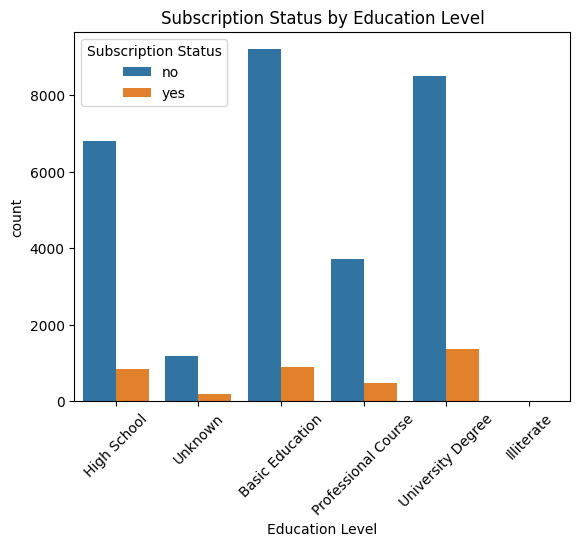

In [38]:
# create plot of subscription (yes and no) vs education level
sns.countplot(x='Education Level', hue='Subscription Status', data=dataset_raw)
plt.xticks(rotation=45)
plt.title('Subscription Status by Education Level')
plt.show()


This plot does not show a significant relationship between education level and subscription status overall. However, it is notable that individuals classified as illiterate have an almost negligible count, suggesting they are rarely targeted or do not subscribe.

In [39]:
# Group by 'Education Level' and 'Subscription Status' and calculate counts
grouped_data = dataset_raw.groupby(['Education Level', 'Subscription Status']).size().unstack(fill_value=0)

# Filter for the 'illiterate' education level
illiterate_data = grouped_data.loc['Illiterate']

# Display the result
print(illiterate_data)



Subscription Status
no     10
yes     4
Name: Illiterate, dtype: int64


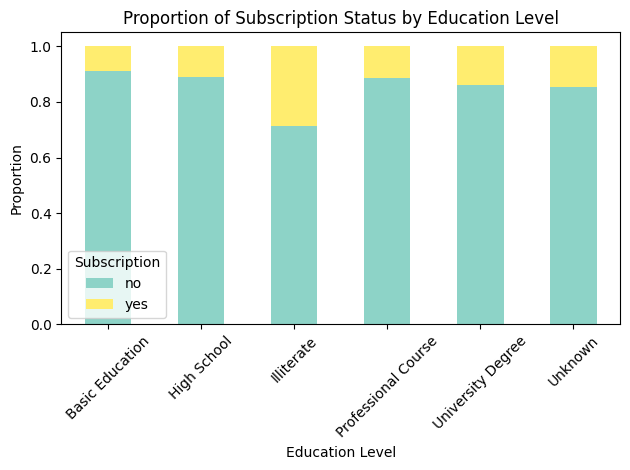

In [40]:
# create proportion to store the data
proportions = pd.crosstab(
    dataset_raw["Education Level"], dataset_raw["Subscription Status"], normalize="index"
)

proportions.plot(kind="bar", stacked=True, colormap="Set3")
plt.title("Proportion of Subscription Status by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Proportion")
plt.legend(title="Subscription")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the proportion chart, the rate across all values similar except for illiterate.
After verifying, the count for Subscription Status of Education Level for group Illiterate is only 10 for no and 4 for yes. This is negligible. So we can drop Education Level from our predictive model.

#### Subscription vs Occupation

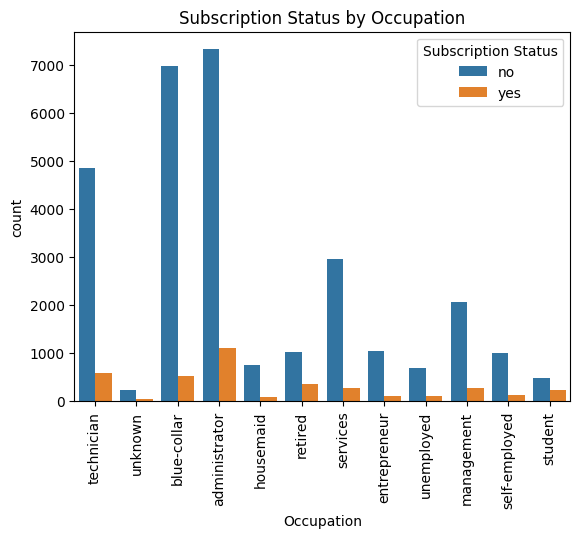

In [41]:
sns.countplot(x='Occupation', hue='Subscription Status', data=dataset_raw)
plt.xticks(rotation=90)
plt.title('Subscription Status by Occupation')
plt.show()

The plot indicates that employed individuals have a higher subscription count compared to those with unknown, entrepreneur, or self-employed job statuses. Notably, students also show a relatively high subscription count, highlighting potential in targeting this segment.

#### Subscription vs Marital Status

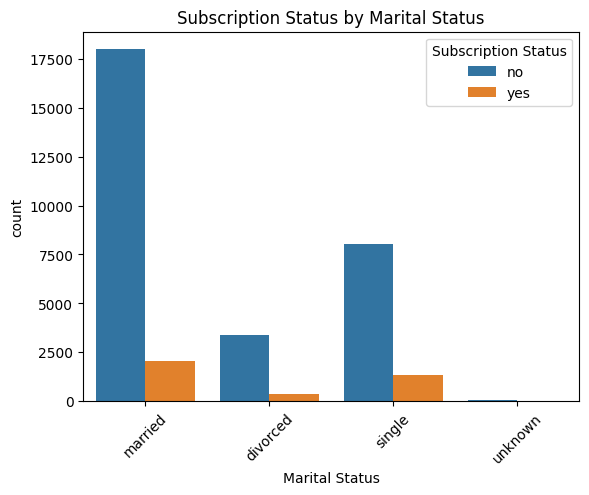

In [42]:
sns.countplot(x='Marital Status', hue='Subscription Status', data=dataset_raw)
plt.xticks(rotation=45)
plt.title('Subscription Status by Marital Status')
plt.show()

The group divorced and unknown has lower subscription counts as compared to married and single.

#### Subscription vs Housing Loan

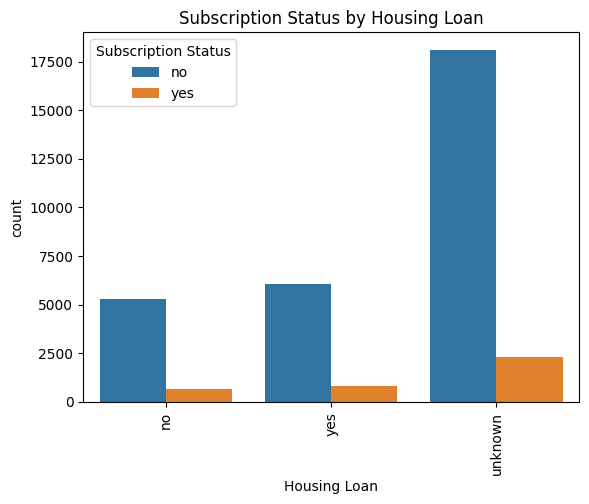

In [43]:
sns.countplot(x="Housing Loan", hue="Subscription Status", data=dataset_raw)
plt.xticks(rotation=90)
plt.title("Subscription Status by Housing Loan")
plt.show()

From the plot, we see that the 'unknown' group (which we earlier treated as missing or NaN values) has a much higher number than both 'yes' and 'no'. The number of 'yes' and 'no' is quite close to each other, but 'unknown' is much more. We don’t know if 'unknown' means missing data, or if it should be counted as 'yes' or 'no'. Because of this confusion, this feature might not be helpful for building a prediction model and may be better to remove.

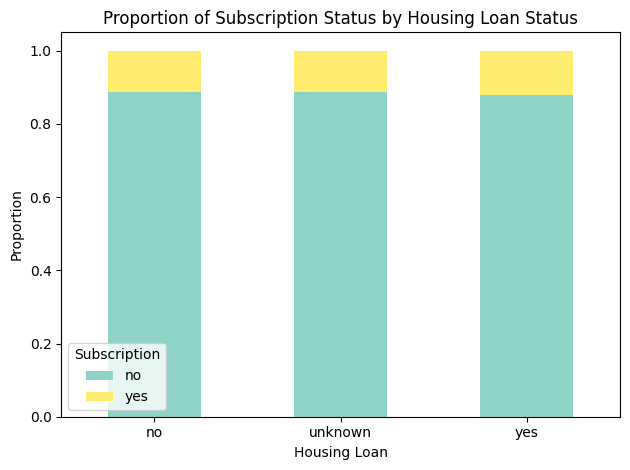

In [44]:
# create proportion to store the data
proportions = pd.crosstab(
    dataset_raw["Housing Loan"], dataset_raw["Subscription Status"], normalize="index"
)

proportions.plot(kind="bar", stacked=True, colormap="Set3")
plt.title("Proportion of Subscription Status by Housing Loan Status")
plt.xlabel("Housing Loan")
plt.ylabel("Proportion")
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Based on the proportion check, we can clearly see that the proportion for Subscription Status "yes" and "no" are the same across all 3 categorical values so we can drop Housing Loan from our predictive modelling.

#### Subscription vs Personal Loan

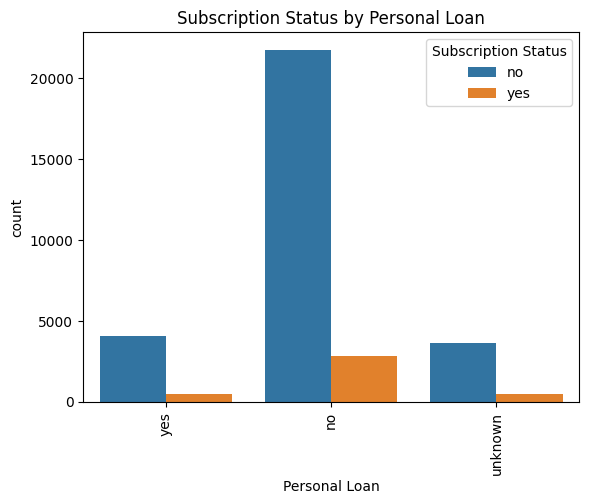

In [45]:
sns.countplot(x="Personal Loan", hue="Subscription Status", data=dataset_raw)
plt.xticks(rotation=90)
plt.title("Subscription Status by Personal Loan")
plt.show()

Based on the plot, "no" has a much higher count than "yes" and "unknown". However, when we look at the subscription status (yes or no), the proportions seem similar across all three categories. We can do a further check to see if these proportions are actually the same across the groups.

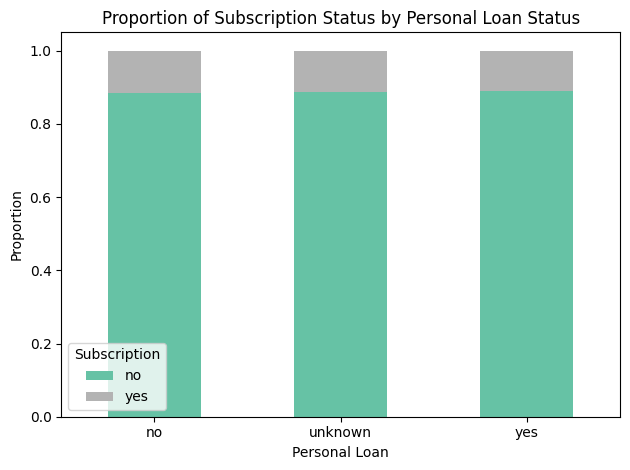

In [46]:
# create proportion to store the data
proportions = pd.crosstab(
    dataset_raw["Personal Loan"], dataset_raw["Subscription Status"], normalize="index"
)

proportions.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Proportion of Subscription Status by Personal Loan Status")
plt.xlabel("Personal Loan")
plt.ylabel("Proportion")
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Based on the proportion check, we can clearly see that the proportion for Subscription Status "yes" and "no" are the same across all 3 categorical values so we can drop Personal Loan from our predictive modelling.

#### Subscription vs Contact Method

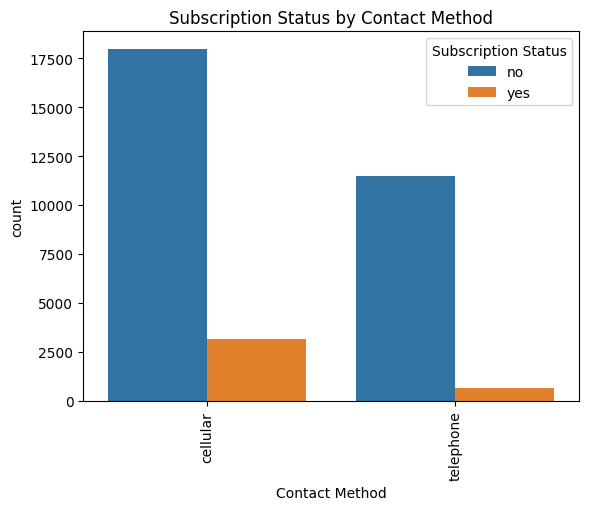

In [47]:
sns.countplot(x='Contact Method', hue='Subscription Status', data=dataset_raw)
plt.xticks(rotation=90)
plt.title('Subscription Status by Contact Method')
plt.show()

Although the contact method via cellular shows a noticeably higher subscription counts compared to telephone, this may be attributed to the significantly larger number of users contacted through cellular. Therefore, this feature may not be a strong standalone predictor of subscription behavior.

#### Subscription vs Credit Default

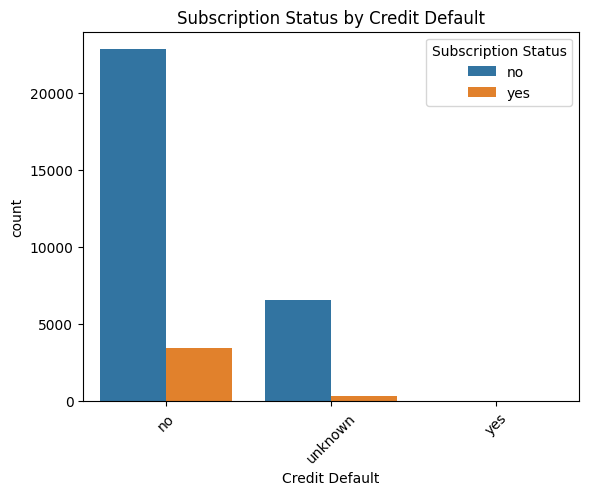

In [48]:
sns.countplot(x='Credit Default', hue='Subscription Status', data=dataset_raw)
plt.xticks(rotation=45)
plt.title('Subscription Status by Credit Default')
plt.show()


Users with no credit default dominate the subscription counts, while those with a credit default or unknown status show significantly lower subscription counts. This may suggest that individuals with a history of defaulting have lower financial engagement, which could contribute to their reduced likelihood of subscribing.

#### Subscription vs Age

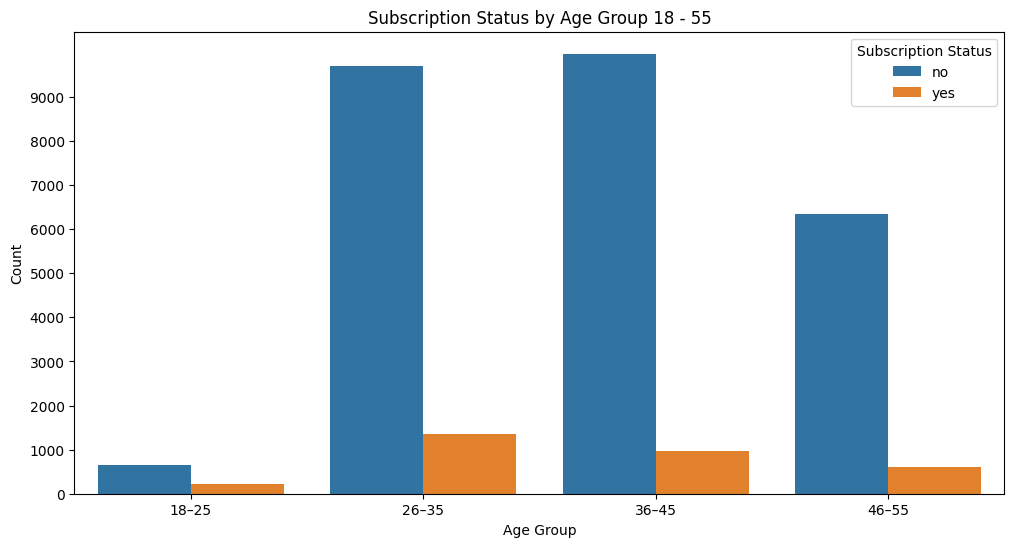

In [49]:
# Age bins
bins = [18, 25, 35, 45, 55 ]
labels = ['18–25', '26–35', '36–45', '46–55']

dataset_raw['Age Group'] = pd.cut(dataset_raw['Age'], bins=bins, labels=labels, right=False)

# Plot the binned age groups
plt.figure(figsize=(12, 6))
sns.countplot(x='Age Group', hue='Subscription Status', data=dataset_raw)
plt.title('Subscription Status by Age Group 18 - 55')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.yticks(range(0, 10000, 1000))
plt.show()

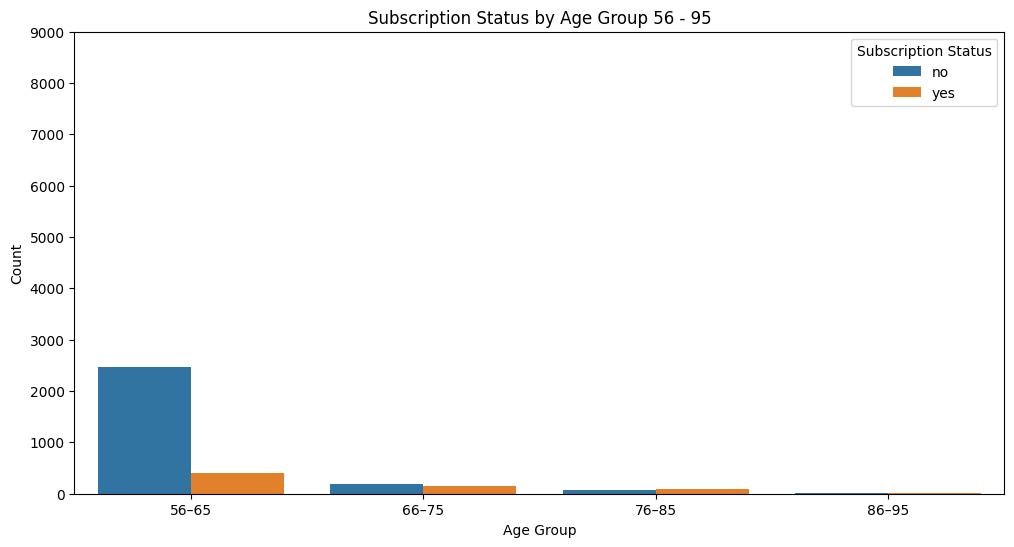

In [50]:
# Age bins 55 to 95
bins = [55, 65, 75, 85, 95]
labels = ['56–65', '66–75', '76–85', '86–95']

dataset_raw['Age Group'] = pd.cut(dataset_raw['Age'], bins=bins, labels=labels, right=False)

# Plot the binned age groups
plt.figure(figsize=(12, 6))
sns.countplot(x='Age Group', hue='Subscription Status', data=dataset_raw)
plt.title('Subscription Status by Age Group 56 - 95')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.yticks(range(0, 10000, 1000))
plt.show()

Age has been grouped into distinct age bands to better observe trends. From the binned data, it is evident that the 26–35 age group has the highest subscription count. Beyond this group, the subscription count steadily declines as age increases, suggesting that younger individuals are more likely to subscribe.

#### Subscription vs Previous Contact Days

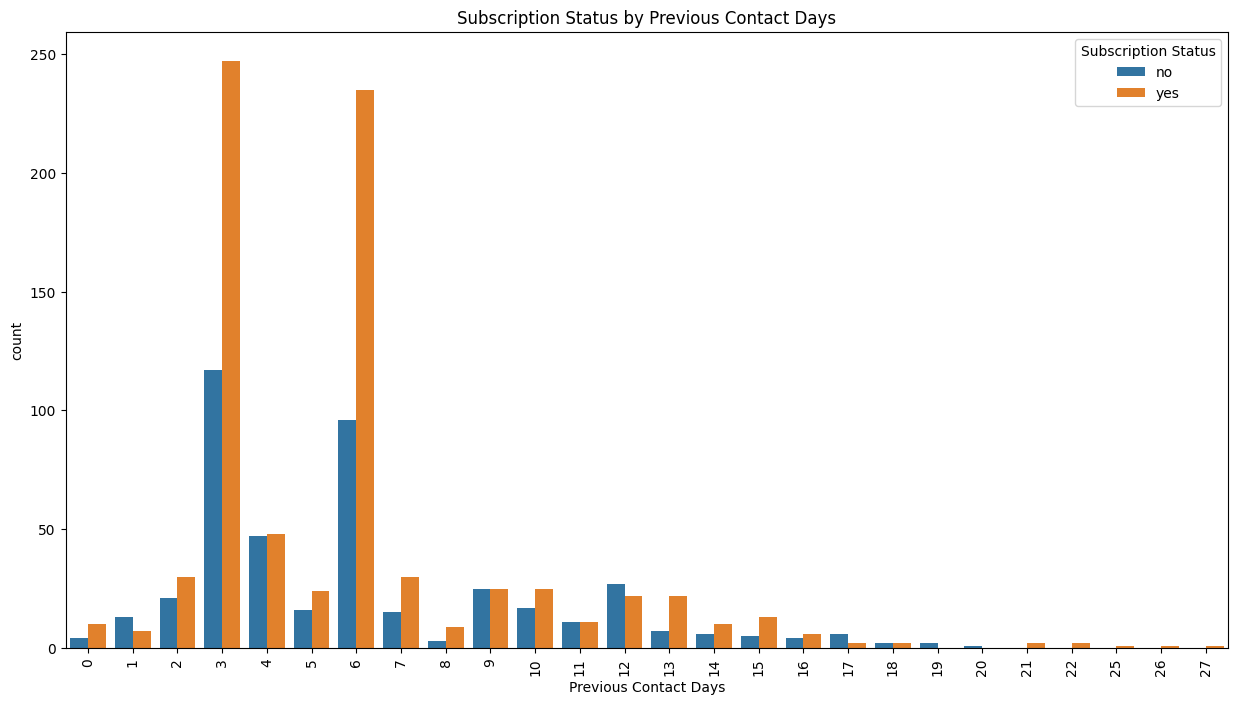

In [51]:
# Filter out rows where 'Previous Contact Days' is 999
filtered_data = dataset_raw[dataset_raw['Previous Contact Days'] != 999]

# Create the countplot after filtering
plt.figure(figsize=(15, 8)) 
sns.countplot(x='Previous Contact Days', hue='Subscription Status', data=filtered_data)
plt.xticks(rotation=90)
plt.title('Subscription Status by Previous Contact Days')
plt.show()

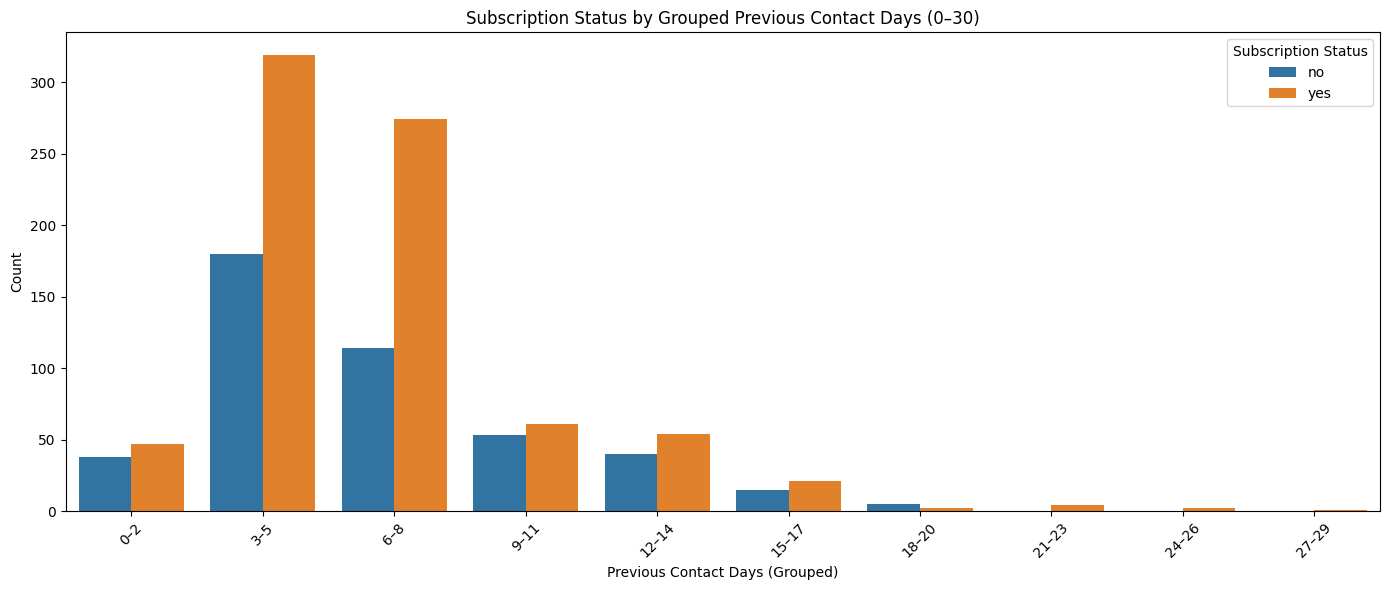

In [52]:
# Filter out 999 values first
filtered_data = dataset_raw[dataset_raw['Previous Contact Days'] != 999].copy()

# Create day bins
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
labels = ['0–2', '3–5', '6–8', '9–11', '12–14', '15–17', '18–20', '21–23', '24–26', '27–29']

# Add binned column to filtered_data
filtered_data['Contact Days Group'] = pd.cut(
    filtered_data['Previous Contact Days'],
    bins=bins,
    labels=labels,
    right=False  # include left bound, exclude right
)


plt.figure(figsize=(14, 6))
sns.countplot(
    x='Contact Days Group',
    hue='Subscription Status',
    data=filtered_data,
    hue_order=['no', 'yes'] 
)
plt.title('Subscription Status by Grouped Previous Contact Days (0–30)')
plt.xlabel('Previous Contact Days (Grouped)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


There is a clear indication that the number of Previous Contact Days significantly influences Subscription Status. Notably, subscriptions begin to increase around Day 3 post-contact and remain consistently high for about a week. After this period, the subscription count gradually declines, with a sharp drop observed after two weeks. This pattern suggests that prior contact positively impacts a customer’s likelihood to subscribe, and that clients often take a few days, particularly around Day 3 onward, to consider and make their decision.

#### Subscription vs No Previous Contact

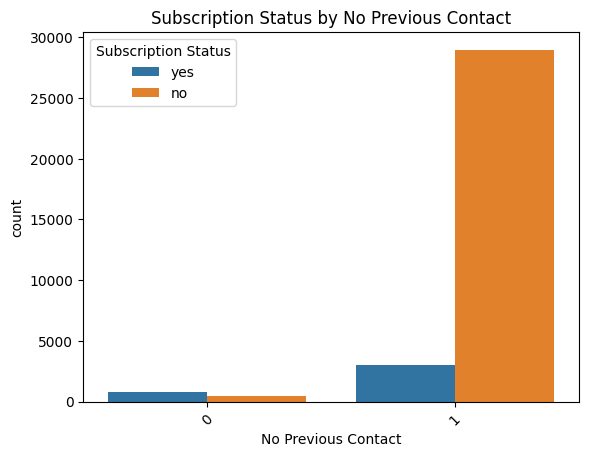

In [53]:
sns.countplot(x="No Previous Contact", hue="Subscription Status", data=dataset_raw)
plt.xticks(rotation=45)
plt.title("Subscription Status by No Previous Contact")
plt.show()

While the overall dataset is dominated by non-subscribers (which is expected in many marketing scenarios), the proportion plot reveals that individuals with previous contact show a noticeably higher subscription rate than those without.

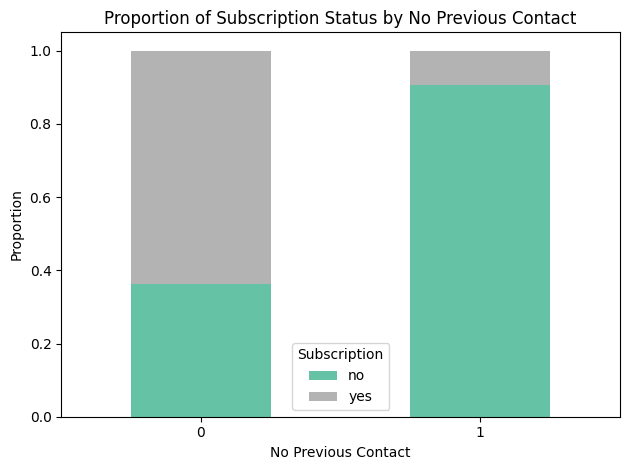

In [54]:
# create proportion to store the data
proportions = pd.crosstab(
    dataset_raw["No Previous Contact"],
    dataset_raw["Subscription Status"],
    normalize="index",
)

proportions.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Proportion of Subscription Status by No Previous Contact")
plt.xlabel("No Previous Contact")
plt.ylabel("Proportion")
plt.legend(title="Subscription")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

0 = No Previous Contact
1 = With Previous Contact

Based on the proportion plot, we observe that the proportion of subscribers is significantly higher among individuals with previous contact compared to those without. This indicates that the "No Previous Contact" feature is informative and should be retained in the model.

#### Subscription vs Campaign Calls

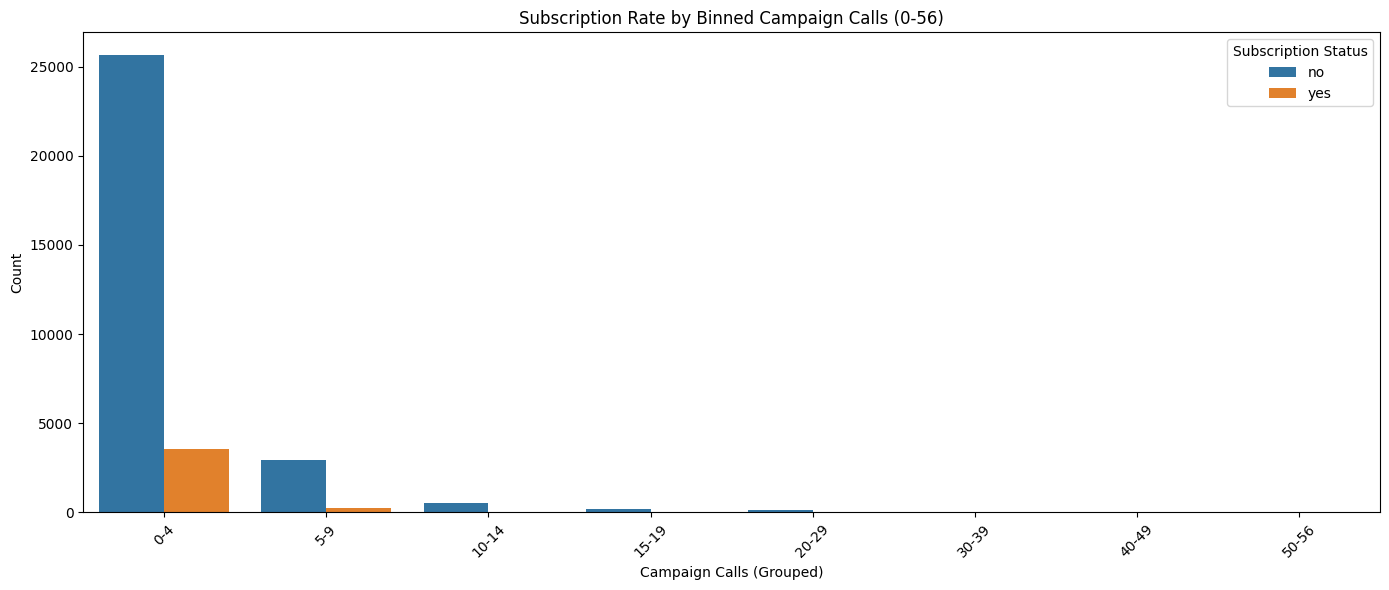

In [55]:
# Create bins for Campaign Calls from 0 to 56
bins = [0, 5, 10, 15, 20, 30, 40, 50, 56]
labels = ['0-4', '5-9', '10-14', '15-19', '20-29', '30-39', '40-49', '50-56']

# Create a new column for the binned Campaign Calls
dataset_raw['Campaign Calls Group'] = pd.cut(dataset_raw['Campaign Calls'], bins=bins, labels=labels, right=False)

# Plot the countplot with binned Campaign Calls
plt.figure(figsize=(14, 6))
sns.countplot(x='Campaign Calls Group', hue='Subscription Status', data=dataset_raw)
plt.title('Subscription Rate by Binned Campaign Calls (0-56)')
plt.xlabel('Campaign Calls (Grouped)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Created another plot to dive into Subscription Status = yes

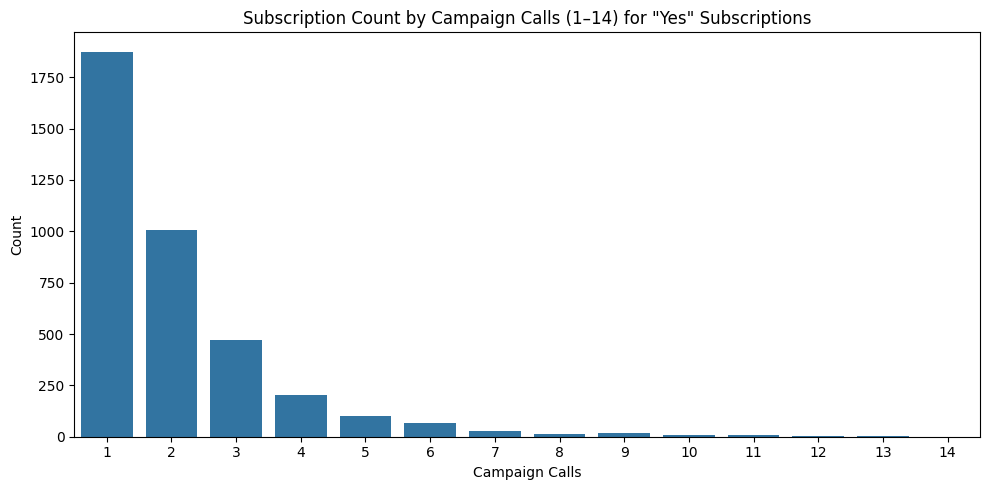

In [56]:
# Filter only rows where 'Campaign Calls' is between 1 and 14 and Subscription Status is 'yes'
filtered_yes = dataset_raw[
    (dataset_raw["Campaign Calls"] <= 14)
    & (dataset_raw["Subscription Status"] == "yes")
]

# Plot the countplot for 'yes' subscription status only
plt.figure(figsize=(10, 5))
sns.countplot(x="Campaign Calls", data=filtered_yes)
plt.title('Subscription Count by Campaign Calls (1–14) for "Yes" Subscriptions')
plt.xlabel("Campaign Calls")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

From this plot, it is evident that an increase in the number of campaign calls does not correlate with a higher subscription rate. In fact, the highest number of subscribers is seen with just 1 call. As the number of calls increases, the subscription count gradually declines. Beyond 10 calls, the number of subscribers drops significantly, approaching zero, indicating that a higher number of calls may not be as effective in converting customers.

---

### Step 5: Conclusion

#### Insights

Based on the two analysis methods the Correlation Matrix and Countplot we observe:

- Correlation Matrix: Most features exhibit weak correlations, indicating limited linear relationships.

- Countplot: Provides more actionable insights, highlighting key features with a stronger impact on subscription status.

Key findings include:

- Age: Younger age groups tend to have higher subscription rates.

- Campaign Calls: A higher number of calls (1 to 10), with 1 call being the most effective.

- Previous Contact Days: The first week after contact (days 3 to 7) yields the best results.

- No Previous Contact: Suggests that prior engagement may positively influence subscription decisions. 

- Credit Default: Clients with "No" credit default status have higher subscription potential.

- Occupation: Employed individuals show higher subscription rates compared to the unemployed, self-employed, and unknown categories.

#### Next Steps

These key features will be used for modeling to build more targeted predictive models.

---

### END